# CoRes-SE
#### including ConvNeXt-ResNet-SE-Mixup-SWA 
#### RAF-DB 


In [ ]:
# ⬇️ Install libraries
!pip install timm albumentations --quiet

# ⬇️ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ⬇️ Import libraries
import os, glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
from timm.loss import SoftTargetCrossEntropy
from timm.scheduler import CosineLRScheduler
from torchvision.models import resnet50
from timm.models import convnext_tiny
import albumentations as A
from albumentations.pytorch import ToTensorV2
from timm.data.mixup import Mixup
from torch.optim.swa_utils import AveragedModel, update_bn

# ⬇️ Data paths
train_dir = "/content/raf-db-dataset/DATASET/train"
test_dir = "/content/raf-db-dataset/DATASET/test"

# ⬇️ Settings
batch_size = 32
learning_rate = 3e-4
weight_decay = 5e-2
num_epochs = 50
num_classes = 7
checkpoint_dir = "/content/drive/MyDrive/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# ⬇️ Mixup
mixup_fn = Mixup(
    mixup_alpha=0.2,
    cutmix_alpha=0.2,
    prob=1.0,
    switch_prob=0.5,
    label_smoothing=0.1,
    num_classes=num_classes
)

# ⬇️ Albumentations transform wrapper
class AlbumentationsTransform:
    def __init__(self, transform): self.transform = transform
    def __call__(self, img):
        img = np.array(img)
        return self.transform(image=img)["image"]

train_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(0.1, 0.1, 15, p=0.5),
    A.GaussianBlur(p=0.2),
    A.CLAHE(p=0.1),
    A.CoarseDropout(max_holes=2, max_height=32, max_width=32, p=0.5),
    A.ColorJitter(0.2, 0.2, 0.2, 0.1),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])
test_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

# ⬇️ SE-Fusion Block
class SEFusion(nn.Module):
    def __init__(self, in_features, reduction=16):
        super(SEFusion, self).__init__()
        self.fc1 = nn.Linear(in_features, in_features // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_features // reduction, in_features, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        w = x.mean(dim=0, keepdim=True)
        w = self.fc1(w)
        w = self.relu(w)
        w = self.fc2(w)
        w = self.sigmoid(w)
        return x * w

# ⬇️ Ensemble model ResNet50 + ConvNeXt-Tiny with SEFusion
class EnsembleModel(nn.Module):
    def __init__(self, num_classes=7):
        super(EnsembleModel, self).__init__()

        self.resnet = resnet50(pretrained=True)
        self.resnet_fc = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()

        self.convnext = convnext_tiny(pretrained=True)
        self.convnext_fc = self.convnext.head.in_features
        self.convnext.head = nn.Identity()

        self.se_fusion = SEFusion(self.resnet_fc + self.convnext_fc)

        self.classifier = nn.Sequential(
            nn.Linear(self.resnet_fc + self.convnext_fc, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        res_feat = self.resnet(x)                      # [B, 2048]
        conv_feat = self.convnext.forward_features(x)  # [B, 768, 7, 7]
        conv_feat = conv_feat.mean(dim=[2, 3])         # GAP → [B, 768]
        combined = torch.cat([res_feat, conv_feat], dim=1)
        fused = self.se_fusion(combined)
        return self.classifier(fused)

# ⬇️ Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=AlbumentationsTransform(train_transforms))
test_dataset = datasets.ImageFolder(test_dir, transform=AlbumentationsTransform(test_transforms))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# ⬇️ Training
device = "cuda" if torch.cuda.is_available() else "cpu"
model = EnsembleModel(num_classes).to(device)
criterion = SoftTargetCrossEntropy()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = CosineLRScheduler(optimizer, t_initial=num_epochs, lr_min=1e-6, warmup_t=3)

# ⬇️ SWA setup
swa_start = int(num_epochs * 0.75)
swa_model = AveragedModel(model)
use_swa = False

# ⬇️ Load checkpoint
start_epoch = 0
checkpoint_files = sorted(glob.glob(f"{checkpoint_dir}/model_epoch_*.pth"))
if checkpoint_files:
    latest_checkpoint = checkpoint_files[-1]
    checkpoint = torch.load(latest_checkpoint, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"✅ Model loaded from {latest_checkpoint}. Resuming from epoch {start_epoch}")
else:
    print("🚀 Starting training from scratch.")

# ⬇️ Training loop
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        if len(images) % 2 != 0: continue
        images, labels = images.to(device), labels.to(device)
        images, labels = mixup_fn(images, labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        _, labels_mix = torch.max(labels, 1)
        correct += (preds == labels_mix).sum().item()
        total += labels.size(0)
        running_loss += loss.item() * images.size(0)

    if epoch >= swa_start:
        swa_model.update_parameters(model)
        use_swa = True

    scheduler.step(epoch)

    # ⬇️ Evaluation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    train_acc = 100 * correct / total
    val_acc = 100 * val_correct / val_total
    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # ⬇️ Save model
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
    }, f"{checkpoint_dir}/model_epoch_{epoch+1}.pth")

# ⬇️ Finalize SWA
if use_swa:
    print("🔁 Finalizing SWA model and updating BatchNorm...")
    update_bn(train_loader, swa_model, device=device)

    swa_model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = swa_model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    swa_val_acc = 100 * val_correct / val_total
    print(f"✅ Final SWA Val Acc: {swa_val_acc:.2f}%")

    # ⬇️ Save SWA model
    torch.save({
        "epoch": num_epochs - 1,
        "model_state": swa_model.state_dict(),
    }, f"{checkpoint_dir}/model_swa_final.pth")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-d8e1b075cacf>:61: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=2, max_height=32, max_width=32, p=0.5),
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` t

🚀 آموزش از ابتدا آغاز می‌شود.
Epoch 1/50 | Train Acc: 13.41% | Val Acc: 6.00%
Epoch 2/50 | Train Acc: 13.50% | Val Acc: 6.19%
Epoch 3/50 | Train Acc: 55.78% | Val Acc: 72.95%
Epoch 4/50 | Train Acc: 63.62% | Val Acc: 74.32%
Epoch 5/50 | Train Acc: 64.74% | Val Acc: 71.51%
Epoch 6/50 | Train Acc: 67.68% | Val Acc: 72.85%
Epoch 7/50 | Train Acc: 68.55% | Val Acc: 75.81%
Epoch 8/50 | Train Acc: 70.20% | Val Acc: 79.04%
Epoch 9/50 | Train Acc: 71.27% | Val Acc: 80.96%
Epoch 10/50 | Train Acc: 72.57% | Val Acc: 81.45%
Epoch 11/50 | Train Acc: 74.17% | Val Acc: 81.84%
Epoch 12/50 | Train Acc: 73.74% | Val Acc: 78.85%
Epoch 13/50 | Train Acc: 74.39% | Val Acc: 83.08%
Epoch 14/50 | Train Acc: 74.96% | Val Acc: 82.86%
Epoch 15/50 | Train Acc: 74.64% | Val Acc: 83.18%
Epoch 16/50 | Train Acc: 77.28% | Val Acc: 85.01%
Epoch 17/50 | Train Acc: 77.59% | Val Acc: 81.58%
Epoch 18/50 | Train Acc: 78.87% | Val Acc: 83.90%
Epoch 19/50 | Train Acc: 78.59% | Val Acc: 83.51%
Epoch 20/50 | Train Acc: 78.63%

## Confusion Matrix 
### (CoRes-SE on RAF-DB)

📊 Classification Report:
              precision    recall  f1-score   support

           1     0.8792    0.8845    0.8818       329
           2     0.9038    0.6351    0.7460        74
           3     0.7231    0.5875    0.6483       160
           4     0.9674    0.9519    0.9596      1185
           5     0.8648    0.8828    0.8737       478
           6     0.8176    0.8580    0.8373       162
           7     0.8386    0.9015    0.8689       680

    accuracy                         0.8911      3068
   macro avg     0.8564    0.8145    0.8308      3068
weighted avg     0.8912    0.8911    0.8899      3068



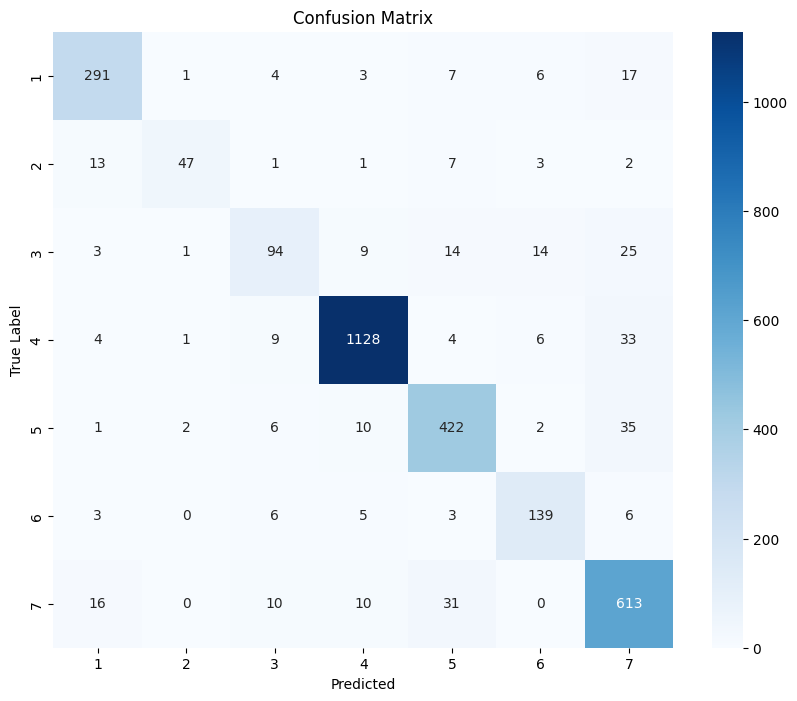

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Classes
class_names = train_dataset.classes  # or ['anger', 'disgust', ..., 'neutral'] if manual

# Predict on the entire test set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Full classification report
print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


 # CoRes-SE
#### including ConvNeXt-ResNet-SE-Mixup-SWA 
#### AffectNet 


In [ ]:
# ⬇️ Install required libraries
!pip install timm albumentations --quiet

# ⬇️ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ⬇️ Import libraries
import os, glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
from timm.loss import SoftTargetCrossEntropy
from timm.scheduler import CosineLRScheduler
from torchvision.models import resnet50
from timm.models import convnext_tiny
import albumentations as A
from albumentations.pytorch import ToTensorV2
from timm.data.mixup import Mixup
from torch.optim.swa_utils import AveragedModel, update_bn

# ⬇️ Dataset directories
train_dir = "/content/affectnet/archive (3)/Train"
test_dir = "/content/affectnet/archive (3)/Test"

# ⬇️ Configuration
batch_size = 32
learning_rate = 3e-4
weight_decay = 5e-2
num_epochs = 30
num_classes = 8  # Changed to 8 classes
checkpoint_dir = "/content/drive/MyDrive/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# ⬇️ Mixup configuration
mixup_fn = Mixup(
    mixup_alpha=0.2,
    cutmix_alpha=0.2,
    prob=1.0,
    switch_prob=0.5,
    label_smoothing=0.1,
    num_classes=num_classes
)

# ⬇️ Albumentations transforms
class AlbumentationsTransform:
    def __init__(self, transform): self.transform = transform
    def __call__(self, img):
        img = np.array(img)
        return self.transform(image=img)["image"]

train_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(0.1, 0.1, 15, p=0.5),
    A.GaussianBlur(p=0.2),
    A.CLAHE(p=0.1),
    A.CoarseDropout(max_holes=2, max_height=32, max_width=32, p=0.5),
    A.ColorJitter(0.2, 0.2, 0.2, 0.1),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])
test_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# ⬇️ SE-Fusion block
class SEFusion(nn.Module):
    def __init__(self, in_features, reduction=16):
        super(SEFusion, self).__init__()
        self.fc1 = nn.Linear(in_features, in_features // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_features // reduction, in_features, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        w = x.mean(dim=0, keepdim=True)
        w = self.fc1(w)
        w = self.relu(w)
        w = self.fc2(w)
        w = self.sigmoid(w)
        return x * w

# ⬇️ Ensemble model: ResNet50 + ConvNeXt-Tiny with SEFusion
class EnsembleModel(nn.Module):
    def __init__(self, num_classes=8):
        super(EnsembleModel, self).__init__()

        self.resnet = resnet50(pretrained=True)
        self.resnet_fc = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()

        self.convnext = convnext_tiny(pretrained=True)
        self.convnext_fc = self.convnext.head.in_features
        self.convnext.head = nn.Identity()

        self.se_fusion = SEFusion(self.resnet_fc + self.convnext_fc)

        self.classifier = nn.Sequential(
            nn.Linear(self.resnet_fc + self.convnext_fc, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        res_feat = self.resnet(x)                      # [B, 2048]
        conv_feat = self.convnext.forward_features(x)  # [B, 768, 7, 7]
        conv_feat = conv_feat.mean(dim=[2, 3])         # Global Average Pooling → [B, 768]
        combined = torch.cat([res_feat, conv_feat], dim=1)
        fused = self.se_fusion(combined)
        return self.classifier(fused)

# ⬇️ Dataset loaders
train_dataset = datasets.ImageFolder(train_dir, transform=AlbumentationsTransform(train_transforms))
test_dataset = datasets.ImageFolder(test_dir, transform=AlbumentationsTransform(test_transforms))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# ⬇️ Training setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model = EnsembleModel(num_classes).to(device)
criterion = SoftTargetCrossEntropy()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = CosineLRScheduler(optimizer, t_initial=num_epochs, lr_min=1e-6, warmup_t=3)

# ⬇️ SWA configuration
swa_start = int(num_epochs * 0.75)
swa_model = AveragedModel(model)
use_swa = False

# ⬇️ Load checkpoint if exists
start_epoch = 0
checkpoint_files = sorted(glob.glob(f"{checkpoint_dir}/model_epoch_*.pth"))
if checkpoint_files:
    latest_checkpoint = checkpoint_files[-1]
    checkpoint = torch.load(latest_checkpoint, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"✅ Model loaded from {latest_checkpoint}. Resuming from epoch {start_epoch}")
else:
    print("🚀 Starting training from scratch.")

# ⬇️ Training loop
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        if len(images) % 2 != 0: continue
        images, labels = images.to(device), labels.to(device)
        images, labels = mixup_fn(images, labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        _, labels_mix = torch.max(labels, 1)
        correct += (preds == labels_mix).sum().item()
        total += labels.size(0)
        running_loss += loss.item() * images.size(0)

    if epoch >= swa_start:
        swa_model.update_parameters(model)
        use_swa = True

    scheduler.step(epoch)

    # ⬇️ Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    train_acc = 100 * correct / total
    val_acc = 100 * val_correct / val_total
    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # ⬇️ Save model checkpoint
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
    }, f"{checkpoint_dir}/model_epoch_{epoch+1}.pth")

# ⬇️ Finalize and evaluate SWA model
if use_swa:
    print("🔁 Finalizing SWA model and updating BatchNorm...")
    update_bn(train_loader, swa_model, device=device)

    swa_model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = swa_model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    swa_val_acc = 100 * val_correct / val_total
    print(f"✅ Final SWA Val Acc: {swa_val_acc:.2f}%")

    # ⬇️ Save final SWA model
    torch.save({
        "epoch": num_epochs - 1,
        "model_state": swa_model.state_dict(),
    }, f"{checkpoint_dir}/model_swa_final.pth")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-9-2688797570>:62: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=2, max_height=32, max_width=32, p=0.5),
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

🚀 آموزش از ابتدا آغاز می‌شود.
Epoch 1/30 | Train Acc: 10.06% | Val Acc: 9.80%
Epoch 2/30 | Train Acc: 10.19% | Val Acc: 9.50%
Epoch 3/30 | Train Acc: 46.67% | Val Acc: 58.94%
Epoch 4/30 | Train Acc: 53.77% | Val Acc: 62.46%
Epoch 5/30 | Train Acc: 54.41% | Val Acc: 63.12%
Epoch 6/30 | Train Acc: 57.57% | Val Acc: 64.06%
Epoch 7/30 | Train Acc: 58.77% | Val Acc: 61.23%
Epoch 8/30 | Train Acc: 60.04% | Val Acc: 65.11%
Epoch 9/30 | Train Acc: 61.94% | Val Acc: 66.96%
Epoch 10/30 | Train Acc: 62.61% | Val Acc: 65.21%
Epoch 11/30 | Train Acc: 62.47% | Val Acc: 68.74%
Epoch 12/30 | Train Acc: 63.99% | Val Acc: 67.25%
Epoch 13/30 | Train Acc: 65.00% | Val Acc: 67.90%
Epoch 14/30 | Train Acc: 65.01% | Val Acc: 69.43%
Epoch 15/30 | Train Acc: 67.72% | Val Acc: 70.56%
Epoch 16/30 | Train Acc: 66.99% | Val Acc: 69.73%
Epoch 17/30 | Train Acc: 68.03% | Val Acc: 70.78%
Epoch 18/30 | Train Acc: 68.42% | Val Acc: 70.59%
Epoch 19/30 | Train Acc: 70.34% | Val Acc: 68.51%
Epoch 20/30 | Train Acc: 69.97%

## Confusion Matrix 
### (CoRes-SE on AffecNet)

📊 Classification Report:
              precision    recall  f1-score   support

       anger     0.7074    0.5320    0.6073      1718
    contempt     0.7479    0.6806    0.7127      1312
     disgust     0.6260    0.5016    0.5569      1248
        fear     0.7348    0.5162    0.6064      1664
       happy     0.9406    0.9253    0.9329      2704
     neutral     0.7350    0.9696    0.8361      2368
         sad     0.5835    0.9659    0.7275      1584
    surprise     0.6088    0.4620    0.5253      1920

    accuracy                         0.7237     14518
   macro avg     0.7105    0.6942    0.6882     14518
weighted avg     0.7286    0.7237    0.7126     14518



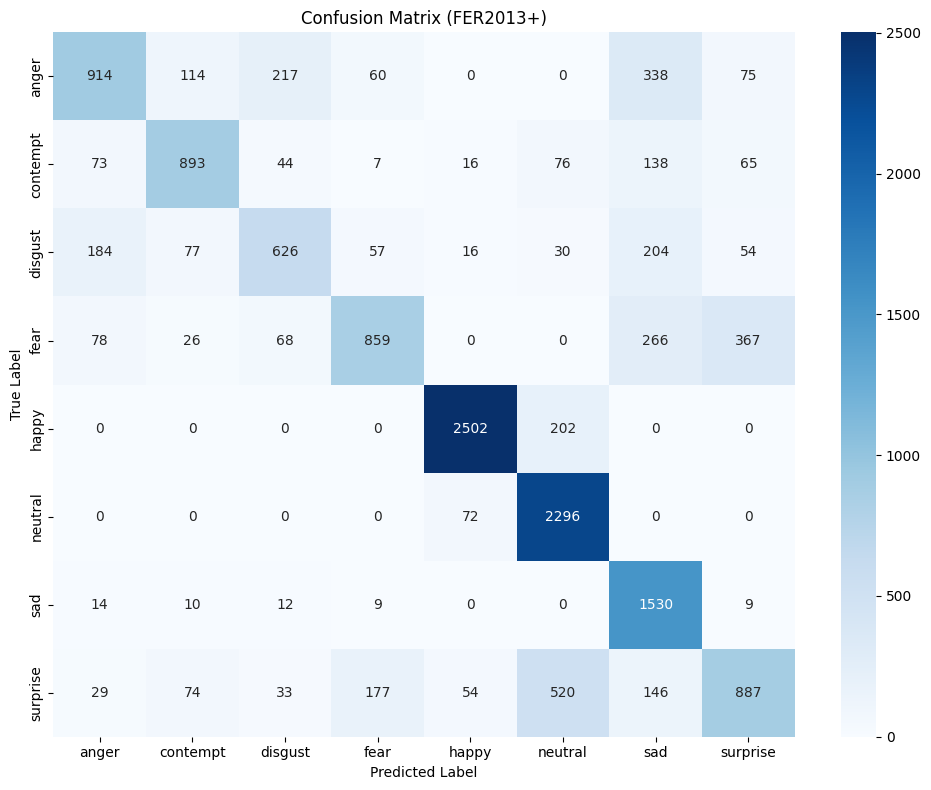

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ⬇️ Manually define class names (exact order for AffectNet with 8 classes)
class_names = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# ⬇️ Predict on the entire test set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ⬇️ Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# ⬇️ Print classification report
print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# ⬇️ Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (FER2013+)')
plt.tight_layout()
plt.show()
